This notebook uses the dataset from House Prices - Advanced Regression Techniques Kaggle competition

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
#import tensorflow as tf
import xgboost as xgb

In [3]:
# Load data
train_df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Drop ID column since it has no use
train_df = train_df.drop("Id", axis=1)

In [5]:
# Inspect columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
# Inspect house price
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

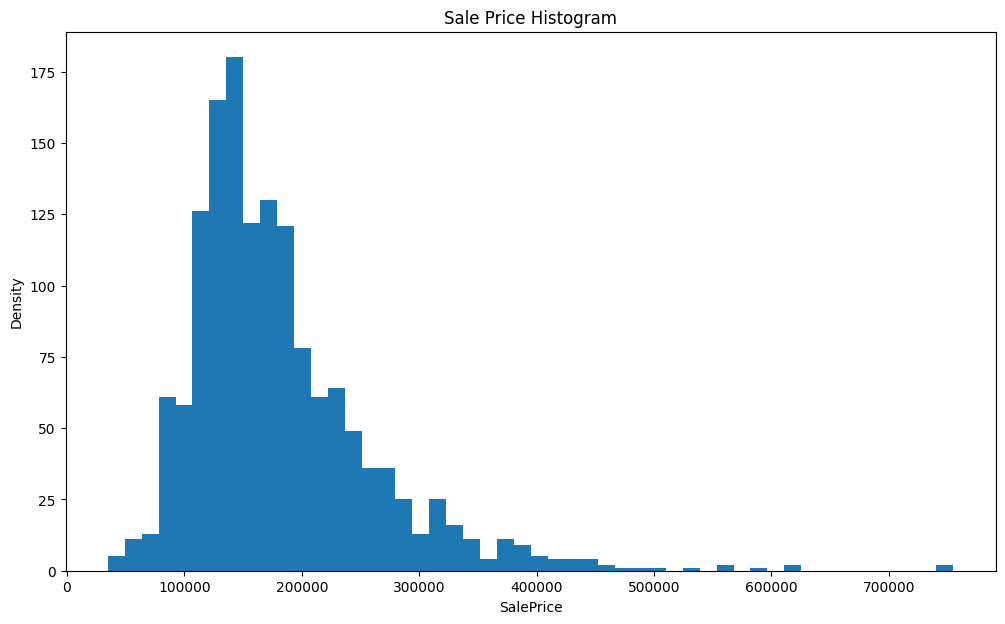

In [7]:
# Check house price distribution
plt.figure(figsize=(12, 7))
plt.hist(train_df["SalePrice"], bins=50)
plt.title("Sale Price Histogram")
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.show()

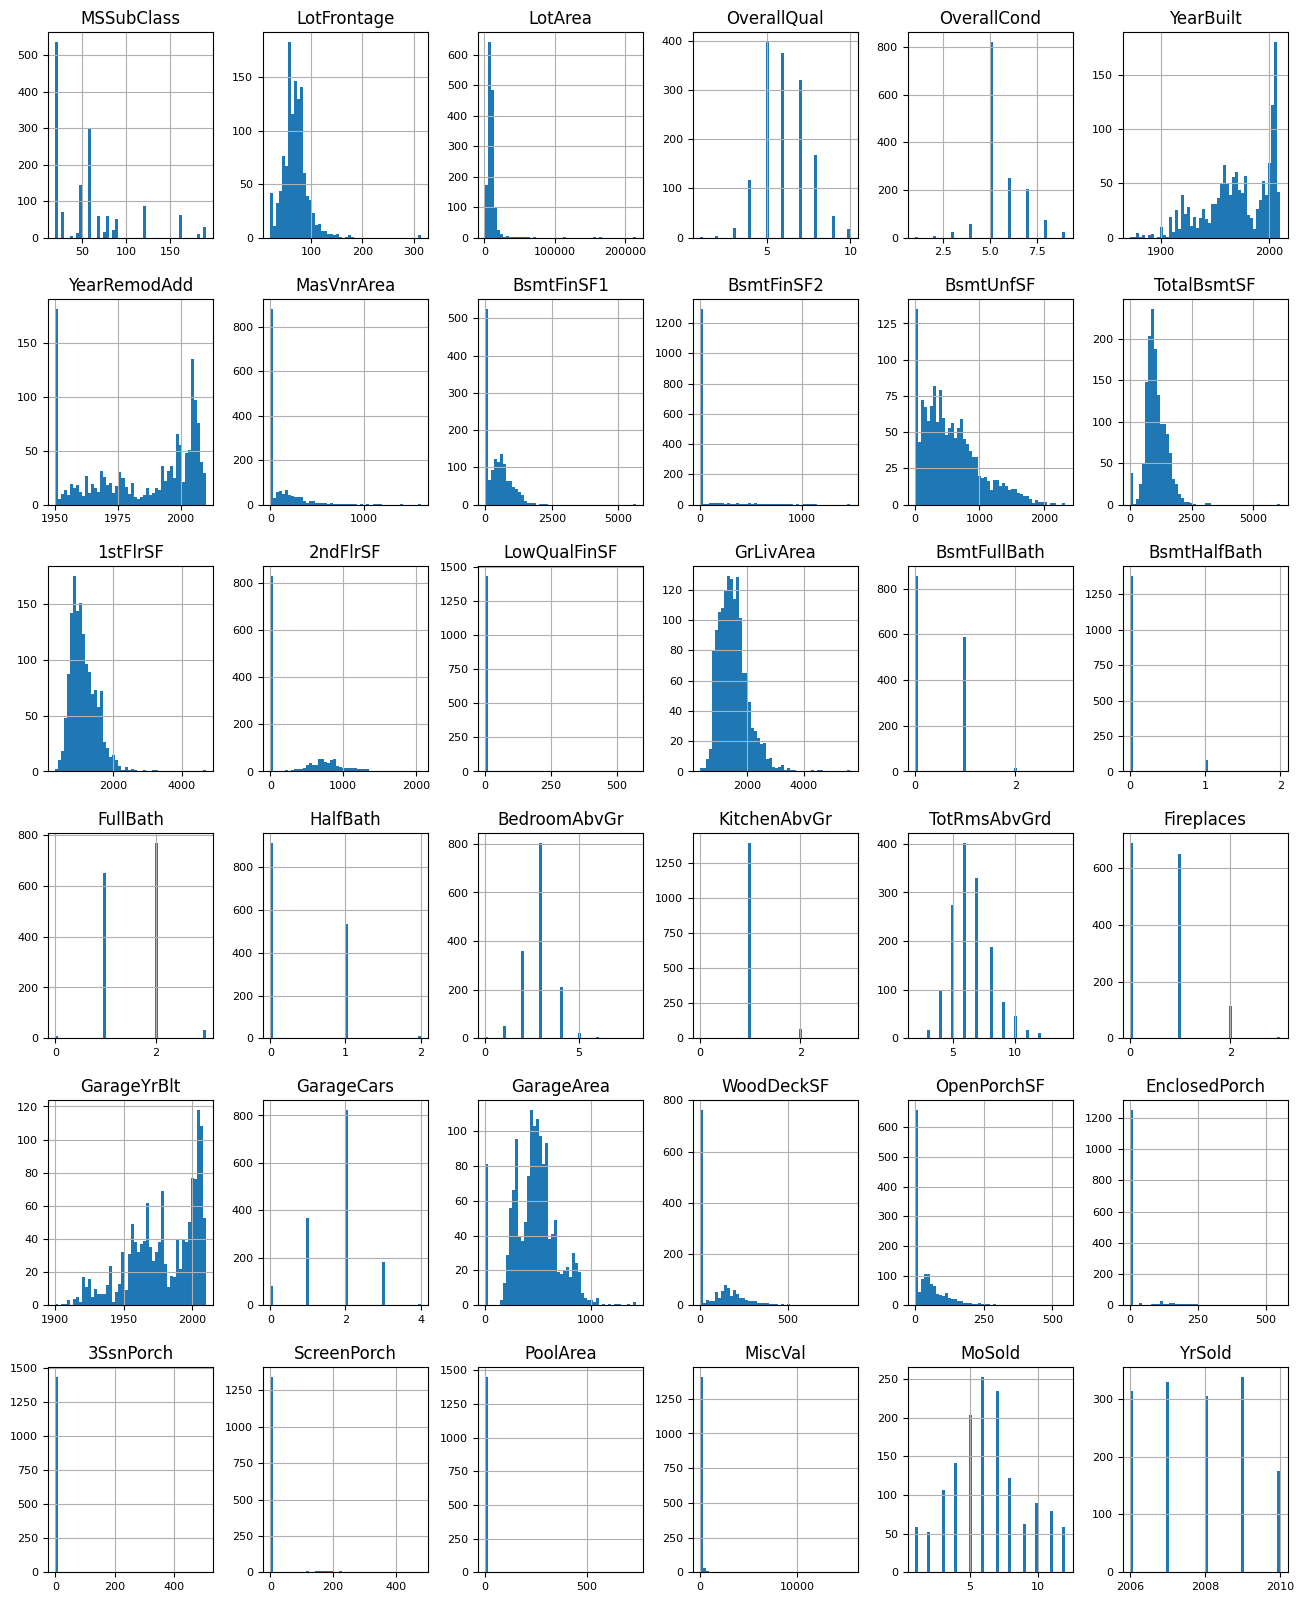

In [8]:
# Check the distributions of the numerical features
numeric_features = train_df.select_dtypes(include=[np.number]).drop("SalePrice", axis=1)
numeric_features.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [9]:
# Check the non-numerical features
non_numeric_features = train_df.select_dtypes(exclude=[np.number])
non_numeric_features

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [10]:
# Look for missing values in numeric features
numeric_features.isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [11]:
# Look for missing values in non-numeric features
non_numeric_features.isna().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [12]:
# Fill missing values
filled_numeric_features = numeric_features.fillna(numeric_features.mean())
filled_non_numeric_features = non_numeric_features.fillna(non_numeric_features.mode().iloc[0])

In [13]:
# Check if there are any missing values remaining in numeric features
(filled_numeric_features.isnull().sum() == 0).value_counts()

True    36
Name: count, dtype: int64

In [14]:
# Check if there are any missing values remaining in non-numeric features
(filled_non_numeric_features.isna().sum() == 0).value_counts()

True    43
Name: count, dtype: int64

In [15]:
# Scale numerical features
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(filled_numeric_features)
numeric_features_scaled = pd.DataFrame(numeric_features_scaled, columns=numeric_features.columns)

# One-hot non-numerical features
#non_numeric_features_encoded = pd.get_dummies(filled_non_numeric_features)

# LabelEncoder leads to lower errors than one-hot encoding in this data
le = LabelEncoder()
non_numeric_features_encoded = pd.DataFrame()
for col in filled_non_numeric_features.columns:
    non_numeric_features_encoded[col] = le.fit_transform(filled_non_numeric_features[col])

# Combine scaled numerical features and encoded non-numerical features
preprocessed_features = pd.concat([numeric_features_scaled, non_numeric_features_encoded], axis=1)
preprocessed_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.511418,0.575425,-0.288653,...,1,1,4,4,2,2,2,2,8,4
1,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574410,1.171992,-0.288653,...,1,1,4,4,2,2,2,2,8,4
2,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.323060,0.092907,-0.288653,...,1,1,4,4,2,2,2,2,8,4
3,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574410,-0.499274,-0.288653,...,5,2,4,4,2,2,2,2,8,0
4,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.364570,0.463568,-0.288653,...,1,1,4,4,2,2,2,2,8,4


In [16]:
# Reduce dimensionality using PCA
#pca = PCA(n_components=10)
#preprocessed_features = pca.fit_transform(preprocessed_features)
#preprocessed_features

In [17]:
# Split data into training and validation data
X_train, X_test, y_train, y_test = train_test_split(preprocessed_features,
                                                    train_df["SalePrice"],
                                                    test_size=0.2,
                                                    random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

1168 292 1168 292


In [18]:
# Create dict to store models' errors
models_rmse = {}

In [19]:
# Train the baseline model (Linear Regression)
# The objective is to beat this simple model in the following experiments
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
models_rmse['Linear'] = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 35445.12783396167


In [20]:
# Experiment with Ridge Regression
model = Ridge()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
models_rmse['Ridge'] = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 34958.2366208605


In [21]:
# Experiment with Lasso Regression
model = Lasso(tol=0.001)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
models_rmse['Lasso'] = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 35290.992458543275


In [22]:
# Experiment with ElasticNet
model = ElasticNet()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
models_rmse['ElasticNet'] = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 35293.428006777416


In [23]:
# Experiment with SVR
model = SVR()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
models_rmse['SVR'] = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 88648.7950122


In [24]:
# Experiment with Random Forest
model = RandomForestRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
models_rmse['RandomForest'] = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 28772.791744168455


In [25]:
# Experiment with Ada Boosting
model = AdaBoostRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
models_rmse['AdaBoost'] = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 35436.3005935135


In [26]:
# Experiment with Gradient Boosting
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
models_rmse['GradientBoosting'] = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 29563.77223363538


In [29]:
# Experiment with XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
models_rmse['XGBoost'] = np.sqrt(mean_squared_error(y_test, preds))

RMSE: 26513.158058344605


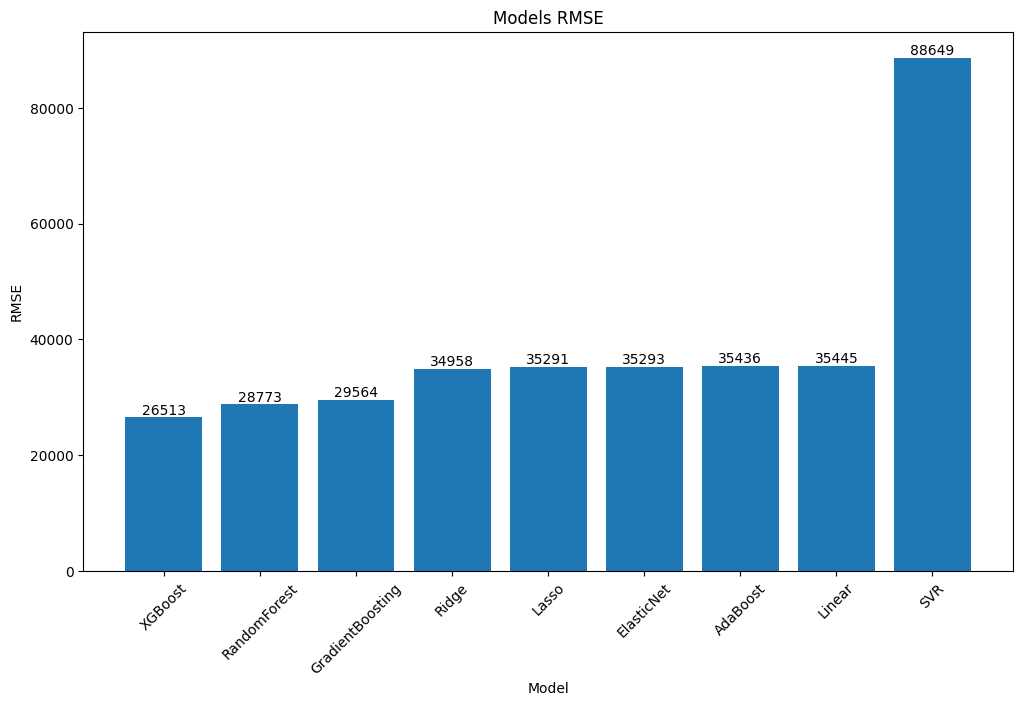

In [30]:
# Show experiments results
results = pd.DataFrame(models_rmse.items(), columns=["Model", "RMSE"]).sort_values("RMSE", ascending=True)
plt.figure(figsize=(12, 7))
bars = plt.bar(results["Model"], results["RMSE"])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, round(yval), ha='center', va='bottom')
plt.title("Models RMSE")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

In [31]:
# Print the best and worst model
print("Best Model:", results["Model"].iloc[0])
print("Worst Model:", results["Model"].iloc[-1])

Best Model: XGBoost
Worst Model: SVR
